# Hazardous Waste: Inspections

## Resource Conservation and Recovery Act Inspections by Congressional District

This notebook examines ECHO data on oversight of the handling of waste, and hazardous waste in particular, uder the Resource Conservation and Recovery Act, or RCRA.  It uses data from the ECHO downloadable files entitled using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_EVALUATIONS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_EVALUATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

From RCRA_EVALUATIONS we get:
<ul>
    <li>EVALUATION_DESC - a description of the evaluation</li>
    <li>EVALUATION_AGENCY - the agency that conducted the evaluation</li>
    <li>EVALUATION_START_DATE</li>
</ul>

A state and congressional district must be chosen using the dropdown
widgets that are provided.

---
---

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Some cells, like the one shown below, will create a dropdown menu after you run them. Be sure to make a selection (for example, click to change NY to LA) before running the next cell.
![Dropdown menu](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/dropdown.JPG?raw=true)
* Other cells will simply print information when you run them, like this one:
![Simple cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/cell-simple.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---
---

# **Let's begin!**

### Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.

### Run this next cell to create the widget for selecting states. It will create a dropdown menu at the bottom. Choose your state from the menu then move on to the next cell.

In [10]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

### Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
#### Here is a map of congressional districts: https://www.govtrack.us/congress/members/map
Note:  Use a CD of 0 to look at the entire state.

In [11]:
cd_widget = widgets.IntText(
    value=1,
    description='Congressional District:',
    disabled=False
)
display( cd_widget )

IntText(value=1, description='Congressional District:')

### Run this cell after choosing a state and congressional district. It will pull facility information from the data  from ECHO_EXPORTER table.

In [50]:
my_state = dropdown_state.value
my_cd = cd_widget.value

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
if ( my_cd > 0 ):
    sql += " and FAC_DERIVED_CD113 = " + str( my_cd )
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'ME'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27ME%27


### Run this cell to load the results of that query.
#### How many facilities in the selected state are tracked for hazardous waste under RCRA?

In [51]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1')
echo_data.set_index( 'REGISTRY_ID', inplace=True )
num_facilities = echo_data.shape[0]

if ( my_cd == 0 ):
    print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))
else:
    print("There are %s RCRA facilities in %s, cd %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))


There are 3026 RCRA facilities in ME tracked in the ECHO database.


### Next look up the inspection history for the facilities in the selected state and congressional district. This step may take a while to run. What we'll get back is a table of facility IDs,their inspections (including descriptions), and dates.
#### How many are there? Below the table, the number of rows listed is the total number of RCRA-related inspections that have occurred over the history of the district since they started tracking in this database.

In [52]:
sql = "select ID_NUMBER, EVALUATION_DESC, EVALUATION_AGENCY, EVALUATION_START_DATE " + \
        " from `RCRA_EVALUATIONS` where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1')
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE
ID_NUMBER,,,
ME3570026051,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/25/1986
ME3971524324,FOCUSED COMPLIANCE INSPECTION,E,06/12/2001
ME4170024539,COMPLIANCE EVALUATION INSPECTION ON-SITE,E,08/10/1994
ME5000000000,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,09/30/1999
ME5000000026,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/20/2008
...,...,...,...
MER000511535,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,05/17/2016
MER000511618,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,10/20/2016
MER000511626,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,09/15/2015


### Evaluation Agency codes are as follows:
<table>
    <tr>
        <td>Code</td>        <td>Description</td>
    </tr>
    <tr>
        <td>B</td>        <td>State/Territory Contractor or Grantee</td>
    </tr>
    <tr>
        <td>C</td>        <td>EPA Contractor or Grantee</td>
    </tr>
    <tr>
        <td>E</td>        <td>EPA</td>
    </tr>
    <tr>
        <td>L</td>        <td>Local</td>
    </tr>
    <tr>
        <td>N</td>        <td>Native American</td>
    </tr>
    <tr>
        <td>S</td>        <td>State/Territory</td>
    </tr>
    <tr>
        <td>T</td>        <td>State/Territory-Initiated Oversight/Observation/Training Actions</td>
    </tr>
    <tr>
        <td>X</td>        <td>EPA-Initiated Oversight/Observation/Training Actions</td>
    </tr>
</table>

### This cell filters the RCRA data to get just records for facilities in the selected state and congressional district.

In [53]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_VIOLATION_HISTORY.
# Build a Dataframe that works as a pivot table between them.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in echo_data.itertuples():
    # ids will be the string from ECHO_EXPORTER containing one or more RCRA_IDs.
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_EVALUATIONS (rcra_data), 
            # if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data[rcra_data.index == rcra_id].copy()
            # n will be the number of rcra records found.
            n = rcra_fac.shape[0]
            if ( n > 0 ):
                # The frame fac_list will contain n copies of the facility.
                df = echo_data[echo_data.index == fac.Index].copy()
                df['REGISTRY_ID'] = fac.Index
                fac_list = pd.concat( [df] * n, ignore_index = True )
                # Concatenate the columns of the facility and the rcra record.
                # The indexes must be dropped for this to work.
                frames = [rcra_fac.reset_index(drop=True), fac_list.reset_index(drop=True)]
                # Concatenate by columns, axis=1
                new_cd_rcra = pd.concat( frames, axis=1, ignore_index=True )
                # Now concatenate the newly constructed rows onto cd_rcra.
                frames = [cd_rcra, new_cd_rcra]
                cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_EVALUATIONS.
            no_data_ids.append( rcra_id )

# cd_rcra is now the dataframe whose rows combine the RCRA_EVALUATIONS record with the 
# facility information 
headers = rcra_data.columns.tolist() + echo_data.columns.tolist() + ['REGISTRY_ID']
cd_rcra.columns = headers
print(cd_rcra)

# my_cd_icis.to_csv( r'cd_rcra.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

                             EVALUATION_DESC EVALUATION_AGENCY  \
0   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     
1   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     
0             NOT A SIGNIFICANT NON-COMPLIER               S     
1                   SIGNIFICANT NON-COMPLIER               S     
2   COMPLIANCE EVALUATION INSPECTION ON-SITE               E     
..                                       ...               ...   
1                   SIGNIFICANT NON-COMPLIER               S     
2   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     
0   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     
1   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     
0   COMPLIANCE EVALUATION INSPECTION ON-SITE               S     

   EVALUATION_START_DATE                       FAC_NAME FAC_STATE    FAC_LAT  \
0             09/26/2000  NORTHEAST LABORATORY SERVICES        ME  44.532140   
1             02/26/2009  NORTHEAST LABORATORY 

## This section optionally saves some of this data to a CSV file in your Google Drive.
The first of the next two cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
**Running these cells is optional.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the state or congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-rcra-inspections-' + my_state
if ( my_cd > 0 ):
    filename += str( my_cd )
filename += '.csv'
cd_rcra.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

## Create an interactive map of all of the facilities in the area that report to EPA under RCRA
### Once you run this cell, a map should appear. You can zoom in and out, or click on facilities to get their names.
The map won't display with too many markers, so only the first 200 are shown.

In [54]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    center = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    m = folium.Map(
        location = center,
        zoom_start = 9
    )
    print( center )
    print( len( df ))

    # Add a clickable marker for each facility
    i = 0
    for index, row in df.iterrows():
        if ( type( row['FAC_NAME'] == str )) :
            folium.Marker(
                location = [row["FAC_LAT"], row["FAC_LONG"]],
                popup = row["FAC_NAME"] ).add_to(m)
            i += 1
        if ( i > 200 ):    # The map won't display with too many markers.
            break

    # Show the map
    return m

map_of_facilities_in_cd = mapper(cd_rcra)
map_of_facilities_in_cd

[44.13714718727365, -69.83836816864972]
1933


## Inspections by facility
### Run the below cell, then choose a facility from the dropdown that appears to delve deeper into inspections at that facility.

In [55]:
cd_array = cd_rcra["FAC_NAME"].dropna().unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('A & T BODY SHOP', 'A.C. ELECTRIC CORP.', 'AC LAWRENCE LEATHER…

### Run this next cell after choosing a facility to print out some details about it

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [56]:
my_fac = cd_rcra[cd_rcra["FAC_NAME"] == w3.value]
my_fac

,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE,FAC_NAME,FAC_STATE,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113,REGISTRY_ID
0,FOCUSED COMPLIANCE INSPECTION,X,12/17/1986,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
1,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,04/10/1987,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
2,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,11/29/1989,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
3,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,09/14/1990,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
4,FOCUSED COMPLIANCE INSPECTION,S,07/18/1986,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
5,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,09/26/1991,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
6,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,05/11/1992,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
7,GROUNDWATER MONITORING EVALUATION,S,09/30/1992,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
8,GROUNDWATER MONITORING EVALUATION,S,09/22/1993,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11
9,GROUNDWATER MONITORING EVALUATION,S,09/15/1994,WATERVILLE IND INC,ME,44.514945,-69.673578,MED001224112,Other,1.0,1.100006e+11


## Plot the number of evaluations by year for the congressional district or state.

                 YEAR_EVALUATION
YEAR_EVALUATION                 
1983                           6
1984                          60
1985                          70
1986                          98
1987                          55
1988                          60
1989                          50
1990                          42
1991                          44
1992                          46
1993                          49
1994                          41
1995                          39
1996                          34
1997                          37
1998                          23
1999                          43
2000                          66
2001                          64
2002                          61
2003                          59
2004                          50
2005                          72
2006                          75
2007                          46
2008                          64
2009                          69
2010                          53
2011      

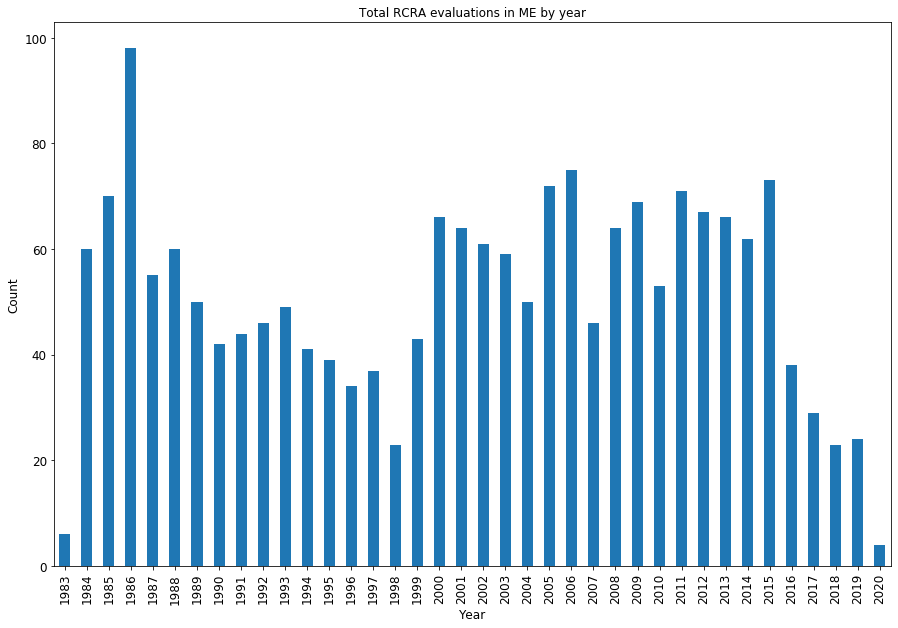

In [57]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

chart_title = "Total RCRA evaluations"
title_where = my_state
if ( my_cd > 0 ):
    title_where += ' - #' + str( my_cd )

show_plot( cd_rcra, 'EVALUATION_START_DATE', 'YEAR_EVALUATION', \
          title_where, '%m/%d/%Y', chart_title )